# Self-Attentive Sequential Recommendation([SASRec](https://arxiv.org/pdf/1808.09781.pdf))



### class 관계

* [AbstractRecommender](https://github.com/RUCAIBox/RecBole/blob/master/recbole/model/abstract_recommender.py#L25)  
    * [SequentialRecommender](https://github.com/RUCAIBox/RecBole/blob/master/recbole/model/abstract_recommender.py#L146)
        * [SASRec](https://github.com/RUCAIBox/RecBole/blob/master/recbole/model/sequential_recommender/sasrec.py)
            * [TransformerEncoder](https://github.com/RUCAIBox/RecBole/blob/master/recbole/model/layers.py#L572)
                * [TransformerLayer](https://github.com/RUCAIBox/RecBole/blob/master/recbole/model/layers.py#L530)
                    * [MultiHeadAttention](https://github.com/RUCAIBox/RecBole/blob/master/recbole/model/layers.py#L385)
                    * [FeedForward](https://github.com/RUCAIBox/RecBole/blob/master/recbole/model/layers.py#L472)
                    
### 그림 참고
* [딥러닝을 이용한 자연어처리 입문](https://wikidocs.net/31379)

### Recbole SASRec 코드실행 예시([참고](https://github.com/RUCAIBox/RecBole/blob/master/run_example/sequential-model-fixed-missing-last-item.ipynb))

    

In [3]:
# Recbole SASRec 코드실행 예시 

# 1. config 
from recbole.config import Config
parameter_dict = {
    'data_path': './data',
    'USER_ID_FIELD': 'user_id',
    'ITEM_ID_FIELD': 'item_id',
    'TIME_FIELD': 'timestamp',
    'user_inter_num_interval': "[30,inf)",
    'item_inter_num_interval': "[40,inf)",
    'load_col': {'inter': ['user_id', 'item_id', 'timestamp']},
    'train_neg_sample_args': None,
    'epochs': 1,
    'eval_args': {
        'split': {'RS': [10, 0, 0]},
        'group_by': 'user',
        'order': 'TO',
        'mode': 'full'}
}
config = Config(model='SASRec', dataset='recbox_data', config_dict=parameter_dict) 

# 2. dataset 
from recbole.data import create_dataset, data_preparation
dataset = create_dataset(config)
train_data, valid_data, test_data = data_preparation(config, dataset)

# 3. model
from recbole.model.sequential_recommender import SASRec
model = SASRec(config, train_data.dataset).to(config['device']) 

# 4. training 
from recbole.trainer import Trainer
trainer = Trainer(config, model)
best_valid_score, best_valid_result = trainer.fit(train_data)

### train data 예시([참고](https://github.com/RUCAIBox/RecBole/blob/master/recbole/trainer/trainer.py#L234))

In [4]:
for batch_idx, batch_data in enumerate(train_data):
    batch_idx = batch_idx
    interaction = batch_data
    break

USER_ID = 'user_id'
POS_ITEM_ID = 'item_id'
ITEM_SEQ = 'item_id_list'
ITEM_SEQ_LEN = 'item_length'

user_seq = interaction[USER_ID] 
item_seq = interaction[ITEM_SEQ]         
item_seq_len = interaction[ITEM_SEQ_LEN] 

In [5]:
user_seq # torch.Size([2048])

tensor([ 8681,  4622, 22968,  ..., 30080, 19206,   759])

In [9]:
item_seq # torch.Size([2048, 50])

tensor([[ 1868,   266,  2206,  ...,     0,     0,     0],
        [ 2549,  2549,    60,  ...,     0,     0,     0],
        [ 1017,   522,   265,  ...,     0,     0,     0],
        ...,
        [ 4208,   818,  6991,  ...,     0,     0,     0],
        [ 3813,  4103,  4103,  ...,  9211, 10242,   265],
        [  181,  1299,  1076,  ...,     0,     0,     0]])

In [10]:
item_seq_len # torch.Size([2048])

tensor([ 7, 26, 13,  ..., 39, 50,  7])

* 유저 8681 학습데이터 예시

In [12]:
import numpy as np
import pandas as pd

uid = train_data.dataset.id2token(train_data.dataset.uid_field, [8681])[0]
index = np.isin(train_data.dataset[ train_data.dataset.uid_field].numpy(), 8681) 

user_interaction = train_data.dataset[index]
user_interaction

# df = pd.read_csv('./data/recbox_data/recbox_data.inter', sep='\t')
# ex = df[df['user_id:token'] == uid] # 유저 8681의 로그는 총 42개 (이중 39개가 train data로 사용)

The batch_size of interaction: 39
    user_id, torch.Size([39]), cpu, torch.int64
    item_id, torch.Size([39]), cpu, torch.int64
    timestamp, torch.Size([39]), cpu, torch.float32
    item_length, torch.Size([39]), cpu, torch.int64
    item_id_list, torch.Size([39, 50]), cpu, torch.int64
    timestamp_list, torch.Size([39, 50]), cpu, torch.float32


In [15]:
user_interaction[USER_ID] # torch.Size([39])

tensor([8681, 8681, 8681, 8681, 8681, 8681, 8681, 8681, 8681, 8681, 8681, 8681,
        8681, 8681, 8681, 8681, 8681, 8681, 8681, 8681, 8681, 8681, 8681, 8681,
        8681, 8681, 8681, 8681, 8681, 8681, 8681, 8681, 8681, 8681, 8681, 8681,
        8681, 8681, 8681])

In [18]:
# x
user_interaction[ITEM_SEQ] # torch.Size([39, 50]) max sequence length = 50

tensor([[1868,    0,    0,  ...,    0,    0,    0],
        [1868,  266,    0,  ...,    0,    0,    0],
        [1868,  266, 2206,  ...,    0,    0,    0],
        ...,
        [1868,  266, 2206,  ...,    0,    0,    0],
        [1868,  266, 2206,  ...,    0,    0,    0],
        [1868,  266, 2206,  ...,    0,    0,    0]])

In [21]:
user_interaction[ITEM_SEQ][-1] 

tensor([ 1868,   266,  2206,  2488,   439,  6038,  5231,  5693,    39,  6429,
         1234,  5944,  3629,   173,  8296,  7010,  6897,  6897,   106,  3858,
         3858,  1196,   643,  5705,  4854,  7869,  8703,  3170,  9258,  9774,
         9362, 10102, 10440, 10334,  8651, 10242,  6997, 10610, 10465,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0])

In [23]:
# y(label)
user_interaction[POS_ITEM_ID] # torch.Size([39])

tensor([  266,  2206,  2488,   439,  6038,  5231,  5693,    39,  6429,  1234,
         5944,  3629,   173,  8296,  7010,  6897,  6897,   106,  3858,  3858,
         1196,   643,  5705,  4854,  7869,  8703,  3170,  9258,  9774,  9362,
        10102, 10440, 10334,  8651, 10242,  6997, 10610, 10465,  2939])

In [24]:
user_interaction[ITEM_SEQ_LEN] # torch.Size([39])

tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
        19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36,
        37, 38, 39])

### SequentialRecommender class
* [code](https://github.com/RUCAIBox/RecBole/blob/master/recbole/model/abstract_recommender.py#L146)

In [65]:
import torch
import torch.nn as nn

In [ ]:
class SequentialRecommender(AbstractRecommender):
    """
    This is a abstract sequential recommender. All the sequential model should implement This class.
    """
    type = ModelType.SEQUENTIAL


```python
def __init__(self, config, dataset):
        super(SequentialRecommender, self).__init__()

        # load dataset info
        self.USER_ID = config["USER_ID_FIELD"]
        self.ITEM_ID = config["ITEM_ID_FIELD"]
        self.ITEM_SEQ = self.ITEM_ID + config["LIST_SUFFIX"]
        self.ITEM_SEQ_LEN = config["ITEM_LIST_LENGTH_FIELD"]
        self.POS_ITEM_ID = self.ITEM_ID
        self.NEG_ITEM_ID = config["NEG_PREFIX"] + self.ITEM_ID
        self.max_seq_length = config["MAX_ITEM_LIST_LENGTH"]
        self.n_items = dataset.num(self.ITEM_ID)

        # load parameters info
        self.device = config["device"]
```

In [25]:
# load dataset info
USER_ID = config["USER_ID_FIELD"] 
ITEM_ID = config["ITEM_ID_FIELD"]  
ITEM_SEQ = ITEM_ID + config["LIST_SUFFIX"]
ITEM_SEQ_LEN = config["ITEM_LIST_LENGTH_FIELD"]

POS_ITEM_ID = ITEM_ID
NEG_ITEM_ID = config["NEG_PREFIX"] + ITEM_ID

max_seq_length = config["MAX_ITEM_LIST_LENGTH"]
n_items = dataset.num(ITEM_ID)

# load parameters info
device = config["device"]

print('USER_ID:', USER_ID)
print('ITEM_ID:', ITEM_ID)
print('ITEM_SEQ:', ITEM_SEQ)
print('ITEM_SEQ_LEN:', ITEM_SEQ_LEN)
print('POS_ITEM_ID:', POS_ITEM_ID)
print('NEG_ITEM_ID:', NEG_ITEM_ID)
print('max_seq_length:', max_seq_length)
print('n_items:', n_items)
print('device:', device)

USER_ID: user_id
ITEM_ID: item_id
ITEM_SEQ: item_id_list
ITEM_SEQ_LEN: item_length
POS_ITEM_ID: item_id
NEG_ITEM_ID: neg_item_id
max_seq_length: 50
n_items: 10962
device: cpu


```python
 def get_attention_mask(self, item_seq, bidirectional=False):
        """Generate left-to-right uni-directional or bidirectional attention mask for multi-head attention."""
        attention_mask = item_seq != 0
        extended_attention_mask = attention_mask.unsqueeze(1).unsqueeze(2)  # torch.bool
        if not bidirectional:
            extended_attention_mask = torch.tril(
                extended_attention_mask.expand((-1, -1, item_seq.size(-1), -1))
            )
        extended_attention_mask = torch.where(extended_attention_mask, 0.0, -10000.0)
        return extended_attention_mask
    
```

In [26]:
# input 
item_seq  # torch.Size([2048, 50])

tensor([[ 1868,   266,  2206,  ...,     0,     0,     0],
        [ 2549,  2549,    60,  ...,     0,     0,     0],
        [ 1017,   522,   265,  ...,     0,     0,     0],
        ...,
        [ 4208,   818,  6991,  ...,     0,     0,     0],
        [ 3813,  4103,  4103,  ...,  9211, 10242,   265],
        [  181,  1299,  1076,  ...,     0,     0,     0]])

In [27]:
item_seq[0]

tensor([1868,  266, 2206, 2488,  439, 6038, 5231,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0])

In [28]:
attention_mask = item_seq != 0  # torch.Size([2048, 50])
attention_mask 

tensor([[ True,  True,  True,  ..., False, False, False],
        [ True,  True,  True,  ..., False, False, False],
        [ True,  True,  True,  ..., False, False, False],
        ...,
        [ True,  True,  True,  ..., False, False, False],
        [ True,  True,  True,  ...,  True,  True,  True],
        [ True,  True,  True,  ..., False, False, False]])

In [29]:
attention_mask[0]

tensor([ True,  True,  True,  True,  True,  True,  True, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False])

In [31]:
extended_attention_mask = attention_mask.unsqueeze(1).unsqueeze(2) # torch.Size([2048, 1, 50]) -> torch.Size([2048, 1, 1, 50])
extended_attention_mask

tensor([[[[ True,  True,  True,  ..., False, False, False]]],


        [[[ True,  True,  True,  ..., False, False, False]]],


        [[[ True,  True,  True,  ..., False, False, False]]],


        ...,


        [[[ True,  True,  True,  ..., False, False, False]]],


        [[[ True,  True,  True,  ...,  True,  True,  True]]],


        [[[ True,  True,  True,  ..., False, False, False]]]])

In [ ]:
bidirectional = False
if not bidirectional:
    tmp = extended_attention_mask.expand((-1, -1, item_seq.size(-1), -1)) # torch.Size([2048, 1, 50, 50])
    extended_attention_mask = torch.tril(tmp)                             # torch.Size([2048, 1, 50, 50])

In [32]:
tmp = extended_attention_mask.expand((-1, -1, item_seq.size(-1), -1)) # torch.Size([2048, 1, 50, 50])
tmp

tensor([[[[ True,  True,  True,  ..., False, False, False],
          [ True,  True,  True,  ..., False, False, False],
          [ True,  True,  True,  ..., False, False, False],
          ...,
          [ True,  True,  True,  ..., False, False, False],
          [ True,  True,  True,  ..., False, False, False],
          [ True,  True,  True,  ..., False, False, False]]],


        [[[ True,  True,  True,  ..., False, False, False],
          [ True,  True,  True,  ..., False, False, False],
          [ True,  True,  True,  ..., False, False, False],
          ...,
          [ True,  True,  True,  ..., False, False, False],
          [ True,  True,  True,  ..., False, False, False],
          [ True,  True,  True,  ..., False, False, False]]],


        [[[ True,  True,  True,  ..., False, False, False],
          [ True,  True,  True,  ..., False, False, False],
          [ True,  True,  True,  ..., False, False, False],
          ...,
          [ True,  True,  True,  ..., False, Fa

In [33]:
tmp[0][0] # # torch.Size([50, 50])

tensor([[ True,  True,  True,  ..., False, False, False],
        [ True,  True,  True,  ..., False, False, False],
        [ True,  True,  True,  ..., False, False, False],
        ...,
        [ True,  True,  True,  ..., False, False, False],
        [ True,  True,  True,  ..., False, False, False],
        [ True,  True,  True,  ..., False, False, False]])

In [38]:
extended_attention_mask = torch.tril(tmp) # torch.Size([2048, 1, 50, 50])
extended_attention_mask

tensor([[[[ True, False, False,  ..., False, False, False],
          [ True,  True, False,  ..., False, False, False],
          [ True,  True,  True,  ..., False, False, False],
          ...,
          [ True,  True,  True,  ..., False, False, False],
          [ True,  True,  True,  ..., False, False, False],
          [ True,  True,  True,  ..., False, False, False]]],


        [[[ True, False, False,  ..., False, False, False],
          [ True,  True, False,  ..., False, False, False],
          [ True,  True,  True,  ..., False, False, False],
          ...,
          [ True,  True,  True,  ..., False, False, False],
          [ True,  True,  True,  ..., False, False, False],
          [ True,  True,  True,  ..., False, False, False]]],


        [[[ True, False, False,  ..., False, False, False],
          [ True,  True, False,  ..., False, False, False],
          [ True,  True,  True,  ..., False, False, False],
          ...,
          [ True,  True,  True,  ..., False, Fa

In [39]:
extended_attention_mask[0][0][0]

tensor([ True, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False])

In [40]:
extended_attention_mask[0][0][1]

tensor([ True,  True, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False])

In [45]:
extended_attention_mask[0][0][6]

tensor([ True,  True,  True,  True,  True,  True,  True, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False])

In [46]:
extended_attention_mask[0][0][7] # 7 ~ 49까지 동일 

tensor([ True,  True,  True,  True,  True,  True,  True, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False])

In [47]:
extended_attention_mask[0][0][49]

tensor([ True,  True,  True,  True,  True,  True,  True, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False])

In [48]:
extended_attention_mask = torch.where(extended_attention_mask, 0.0, -10000.0) # torch.Size([2048, 1, 50, 50])

In [49]:
extended_attention_mask

tensor([[[[     0., -10000., -10000.,  ..., -10000., -10000., -10000.],
          [     0.,      0., -10000.,  ..., -10000., -10000., -10000.],
          [     0.,      0.,      0.,  ..., -10000., -10000., -10000.],
          ...,
          [     0.,      0.,      0.,  ..., -10000., -10000., -10000.],
          [     0.,      0.,      0.,  ..., -10000., -10000., -10000.],
          [     0.,      0.,      0.,  ..., -10000., -10000., -10000.]]],


        [[[     0., -10000., -10000.,  ..., -10000., -10000., -10000.],
          [     0.,      0., -10000.,  ..., -10000., -10000., -10000.],
          [     0.,      0.,      0.,  ..., -10000., -10000., -10000.],
          ...,
          [     0.,      0.,      0.,  ..., -10000., -10000., -10000.],
          [     0.,      0.,      0.,  ..., -10000., -10000., -10000.],
          [     0.,      0.,      0.,  ..., -10000., -10000., -10000.]]],


        [[[     0., -10000., -10000.,  ..., -10000., -10000., -10000.],
          [     0.,      0

```python
 def gather_indexes(self, output, gather_index):
        """Gathers the vectors at the specific positions over a minibatch"""
        gather_index = gather_index.view(-1, 1, 1).expand(-1, -1, output.shape[-1])
        output_tensor = output.gather(dim=1, index=gather_index)
        return output_tensor.squeeze(1)
```

In [52]:
# input 
output = torch.rand([2048, 50, 64]) # output 예시
gather_index = item_seq_len - 1     # torch.Size([2048])

In [53]:
gather_index

tensor([ 6, 25, 12,  ..., 38, 49,  6])

In [54]:
gather_index = gather_index.view(-1, 1, 1).expand(-1, -1, output.shape[-1]) # torch.Size([2048, 1, 1]) -> [2048, 1, 64]
gather_index

tensor([[[ 6,  6,  6,  ...,  6,  6,  6]],

        [[25, 25, 25,  ..., 25, 25, 25]],

        [[12, 12, 12,  ..., 12, 12, 12]],

        ...,

        [[38, 38, 38,  ..., 38, 38, 38]],

        [[49, 49, 49,  ..., 49, 49, 49]],

        [[ 6,  6,  6,  ...,  6,  6,  6]]])

In [55]:
output_tensor = output.gather(dim=1, index=gather_index) # torch.Size([2048, 1, 64])

# output[0][6]
# output[1][25]
# ...
# output[2047][6]

In [56]:
output_tensor

tensor([[[0.0320, 0.4300, 0.1542,  ..., 0.1900, 0.8480, 0.5424]],

        [[0.3069, 0.4541, 0.0528,  ..., 0.8476, 0.6264, 0.6698]],

        [[0.0131, 0.2552, 0.2702,  ..., 0.0176, 0.9185, 0.1752]],

        ...,

        [[0.7754, 0.5159, 0.2408,  ..., 0.2827, 0.5453, 0.8278]],

        [[0.8666, 0.7152, 0.2644,  ..., 0.1230, 0.5616, 0.8798]],

        [[0.6902, 0.2934, 0.7709,  ..., 0.3917, 0.8086, 0.0504]]])

In [57]:
output[0][6]

tensor([0.0320, 0.4300, 0.1542, 0.0019, 0.3915, 0.0605, 0.1935, 0.6811, 0.5048,
        0.3541, 0.6980, 0.4920, 0.4206, 0.1087, 0.1328, 0.2339, 0.0416, 0.4659,
        0.7262, 0.5235, 0.0957, 0.5303, 0.6733, 0.7423, 0.9876, 0.5838, 0.1462,
        0.7638, 0.6565, 0.3153, 0.6075, 0.4204, 0.0161, 0.0368, 0.7844, 0.0072,
        0.5428, 0.8369, 0.2896, 0.3736, 0.8334, 0.6844, 0.2207, 0.3696, 0.0388,
        0.9414, 0.8661, 0.6743, 0.4789, 0.2714, 0.4282, 0.6675, 0.1873, 0.0504,
        0.5365, 0.9650, 0.1889, 0.7426, 0.0550, 0.3698, 0.6055, 0.1900, 0.8480,
        0.5424])

In [60]:
output[1][25]

tensor([0.3069, 0.4541, 0.0528, 0.7933, 0.7326, 0.9650, 0.4293, 0.9217, 0.0565,
        0.1969, 0.7149, 0.6095, 0.5099, 0.5188, 0.8574, 0.8394, 0.0267, 0.6900,
        0.3555, 0.2192, 0.2323, 0.1542, 0.0817, 0.1590, 0.0681, 0.8346, 0.7143,
        0.3378, 0.2859, 0.7785, 0.9668, 0.8525, 0.0838, 0.4283, 0.4188, 0.2971,
        0.5262, 0.4591, 0.9092, 0.6489, 0.6712, 0.7706, 0.7793, 0.5896, 0.7011,
        0.9960, 0.3039, 0.4623, 0.9865, 0.3380, 0.6413, 0.6226, 0.4300, 0.7187,
        0.6727, 0.4492, 0.6484, 0.8844, 0.3546, 0.3703, 0.8179, 0.8476, 0.6264,
        0.6698])

In [58]:
output_tensor = output_tensor.squeeze(1) # torch.Size([2048, 64])

In [59]:
output_tensor

tensor([[0.0320, 0.4300, 0.1542,  ..., 0.1900, 0.8480, 0.5424],
        [0.3069, 0.4541, 0.0528,  ..., 0.8476, 0.6264, 0.6698],
        [0.0131, 0.2552, 0.2702,  ..., 0.0176, 0.9185, 0.1752],
        ...,
        [0.7754, 0.5159, 0.2408,  ..., 0.2827, 0.5453, 0.8278],
        [0.8666, 0.7152, 0.2644,  ..., 0.1230, 0.5616, 0.8798],
        [0.6902, 0.2934, 0.7709,  ..., 0.3917, 0.8086, 0.0504]])

# Transformer

* TransformerEncoder
    * TransformerLayer
        * MultiHeadAttention
        * FeedForward
    

### MultiHeadAttention class
* [code](https://github.com/RUCAIBox/RecBole/blob/master/recbole/model/layers.py#L385)

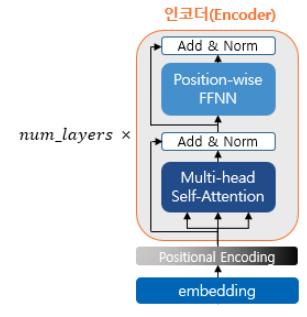

In [63]:
import math

In [ ]:
class MultiHeadAttention(nn.Module):
    """
    Multi-head Self-attention layers, a attention score dropout layer is introduced.
    Args:
        input_tensor (torch.Tensor): the input of the multi-head self-attention layer
        attention_mask (torch.Tensor): the attention mask for input tensor
    Returns:
        hidden_states (torch.Tensor): the output of the multi-head self-attention layer
    """

```python
def __init__(
        self,
        n_heads,
        hidden_size,
        hidden_dropout_prob,
        attn_dropout_prob,
        layer_norm_eps,
    ):
        super(MultiHeadAttention, self).__init__()
        if hidden_size % n_heads != 0:
            raise ValueError(
                "The hidden size (%d) is not a multiple of the number of attention "
                "heads (%d)" % (hidden_size, n_heads)
            )

        self.num_attention_heads = n_heads
        self.attention_head_size = int(hidden_size / n_heads)
        self.all_head_size = self.num_attention_heads * self.attention_head_size
        self.sqrt_attention_head_size = math.sqrt(self.attention_head_size)

        self.query = nn.Linear(hidden_size, self.all_head_size) # w_q (hidden_size, hidden_size)
        self.key = nn.Linear(hidden_size, self.all_head_size)   # w_k (hidden_size, hidden_size)
        self.value = nn.Linear(hidden_size, self.all_head_size) # w_v (hidden_size, hidden_size)

        self.softmax = nn.Softmax(dim=-1)
        self.attn_dropout = nn.Dropout(attn_dropout_prob)

        self.dense = nn.Linear(hidden_size, hidden_size)
        self.LayerNorm = nn.LayerNorm(hidden_size, eps=layer_norm_eps)
        self.out_dropout = nn.Dropout(hidden_dropout_prob)
```

In [61]:
n_heads = 2
hidden_size = 64
hidden_dropout_prob = 0.1
attn_dropout_prob = 0.1
layer_norm_eps = 0.001

In [66]:
num_attention_heads = n_heads
attention_head_size = int(hidden_size / n_heads)          # 64/2 = 32 
all_head_size = num_attention_heads * attention_head_size # hidden_size
sqrt_attention_head_size = math.sqrt(attention_head_size)

query = nn.Linear(hidden_size, all_head_size) # w_q (hidden_size, hidden_size)
key = nn.Linear(hidden_size, all_head_size)   # w_k (hidden_size, hidden_size)
value = nn.Linear(hidden_size, all_head_size) # w_v (hidden_size, hidden_size)

softmax = nn.Softmax(dim=-1)
attn_dropout = nn.Dropout(attn_dropout_prob)

dense = nn.Linear(hidden_size, hidden_size)
LayerNorm = nn.LayerNorm(hidden_size, eps=layer_norm_eps)
out_dropout = nn.Dropout(hidden_dropout_prob)

```python
 def forward(self, input_tensor, attention_mask):
        
        mixed_query_layer = self.query(input_tensor) # w_q * q
        mixed_key_layer = self.key(input_tensor)     # w_k * k 
        mixed_value_layer = self.value(input_tensor) # w_v * v

        query_layer = self.transpose_for_scores(mixed_query_layer).permute(0, 2, 1, 3)
        key_layer = self.transpose_for_scores(mixed_key_layer).permute(0, 2, 3, 1)
        value_layer = self.transpose_for_scores(mixed_value_layer).permute(0, 2, 1, 3)

        # Take the dot product between "query" and "key" to get the raw attention scores.
        attention_scores = torch.matmul(query_layer, key_layer)

        attention_scores = attention_scores / self.sqrt_attention_head_size
        # Apply the attention mask is (precomputed for all layers in BertModel forward() function)
        # [batch_size heads seq_len seq_len] scores
        # [batch_size 1 1 seq_len]
        attention_scores = attention_scores + attention_mask

        # Normalize the attention scores to probabilities.
        attention_probs = self.softmax(attention_scores)
        # This is actually dropping out entire tokens to attend to, which might
        # seem a bit unusual, but is taken from the original Transformer paper.

        attention_probs = self.attn_dropout(attention_probs)
        context_layer = torch.matmul(attention_probs, value_layer)
        context_layer = context_layer.permute(0, 2, 1, 3).contiguous()
        new_context_layer_shape = context_layer.size()[:-2] + (self.all_head_size,)
        context_layer = context_layer.view(*new_context_layer_shape)
        hidden_states = self.dense(context_layer)
        hidden_states = self.out_dropout(hidden_states)
        hidden_states = self.LayerNorm(hidden_states + input_tensor)

        return hidden_states
```

In [68]:
# input 
max_seq_len = 50
batch_size = 2048

input_tensor = torch.rand([batch_size, max_seq_len, hidden_size]) # torch.Size([2048, 50, 64]) input_emb of SASRes
attention_mask = extended_attention_mask                          # torch.Size([2048, 1, 50, 50])

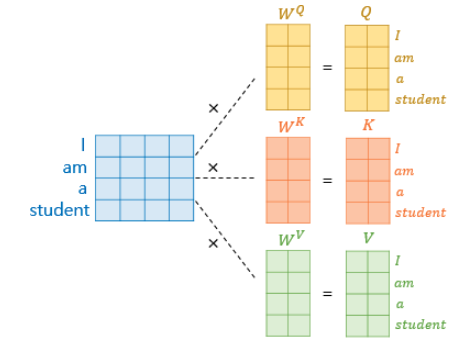

In [69]:
mixed_query_layer = query(input_tensor) # torch.Size([2048, 50, 64])  
mixed_key_layer = key(input_tensor)     # torch.Size([2048, 50, 64])  
mixed_value_layer = value(input_tensor) # torch.Size([2048, 50, 64])  

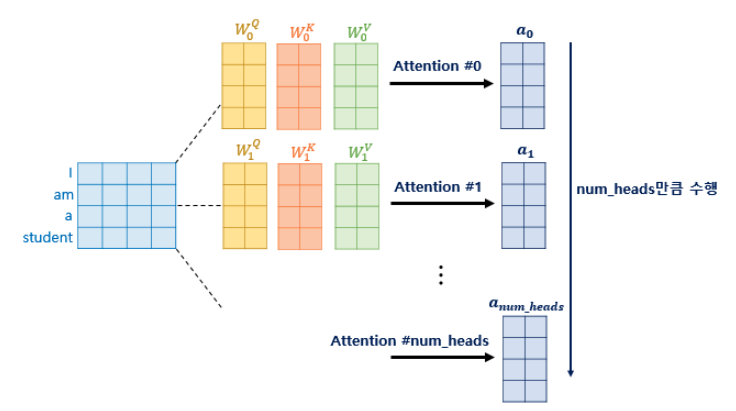

In [70]:
def transpose_for_scores(x):
    num_attention_heads = 2
    attention_head_size = 32 
    new_x_shape = x.size()[:-1] + (num_attention_heads, attention_head_size,) # torch.Size([2048, 50, 2, 32])
    x = x.view(*new_x_shape) # torch.Size([2048, 50, 2, 32])
    return x

query_layer = transpose_for_scores(mixed_query_layer).permute(0, 2, 1, 3) # torch.Size([2048, 2, 50, 32])
key_layer = transpose_for_scores(mixed_key_layer).permute(0, 2, 3, 1)     # torch.Size([2048, 2, 50, 32])
value_layer = transpose_for_scores(mixed_value_layer).permute(0, 2, 1, 3) # torch.Size([2048, 2, 50, 32]) 

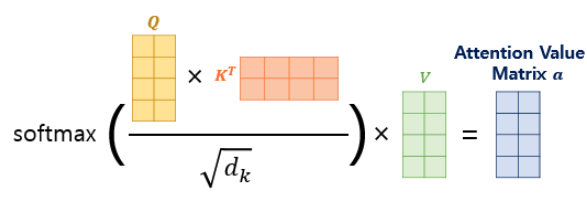

In [72]:
attention_scores = torch.matmul(query_layer, key_layer) # torch.Size([2048, 2, 50, 50])
attention_scores = attention_scores / sqrt_attention_head_size
attention_scores = attention_scores + attention_mask    # [batch_size, num_heads, max_seq_len, max_seq_len] 
attention_probs = softmax(attention_scores)

attention_probs

tensor([[[[1.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.5373, 0.4627, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.3502, 0.3081, 0.3417,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.1432, 0.1263, 0.1351,  ..., 0.0000, 0.0000, 0.0000],
          [0.1418, 0.1229, 0.1352,  ..., 0.0000, 0.0000, 0.0000],
          [0.1428, 0.1263, 0.1391,  ..., 0.0000, 0.0000, 0.0000]],

         [[1.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.4831, 0.5169, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.3075, 0.3405, 0.3520,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.1341, 0.1404, 0.1511,  ..., 0.0000, 0.0000, 0.0000],
          [0.1320, 0.1370, 0.1488,  ..., 0.0000, 0.0000, 0.0000],
          [0.1349, 0.1423, 0.1491,  ..., 0.0000, 0.0000, 0.0000]]],


        [[[1.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.4948, 0.5052, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.3324, 0.3172, 0.3504,  ...,

In [73]:
attention_probs = attn_dropout(attention_probs) # dropout layer
context_layer = torch.matmul(attention_probs, value_layer) # torch.Size([2048, 2, 50, 32])

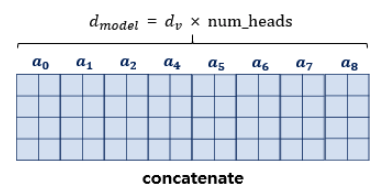

In [74]:
context_layer = context_layer.permute(0, 2, 1, 3).contiguous()         # torch.Size([2048, 50, 2, 32])
new_context_layer_shape = context_layer.size()[:-2] + (all_head_size,) # (2048, 50, 64)
context_layer = context_layer.view(*new_context_layer_shape)           # torch.Size([2048, 50, 64])

In [75]:
hidden_states = dense(context_layer)                       # torch.Size([2048, 50, 64])
hidden_states = out_dropout(hidden_states)                 # torch.Size([2048, 50, 64])
attention_output = LayerNorm(hidden_states + input_tensor) # torch.Size([2048, 50, 64])

### FeedForward class
* [code](https://github.com/RUCAIBox/RecBole/blob/master/recbole/model/layers.py#L472)

In [ ]:
class FeedForward(nn.Module):
    """
    Point-wise feed-forward layer is implemented by two dense layers.
    Args:
        input_tensor (torch.Tensor): the input of the point-wise feed-forward layer
    Returns:
        hidden_states (torch.Tensor): the output of the point-wise feed-forward layer
    """


```python

    def __init__(
        self, hidden_size, inner_size, hidden_dropout_prob, hidden_act, layer_norm_eps
    ):
        super(FeedForward, self).__init__()
        self.dense_1 = nn.Linear(hidden_size, inner_size)
        self.intermediate_act_fn = self.get_hidden_act(hidden_act)

        self.dense_2 = nn.Linear(inner_size, hidden_size)
        self.LayerNorm = nn.LayerNorm(hidden_size, eps=layer_norm_eps)
        self.dropout = nn.Dropout(hidden_dropout_prob)

```

In [76]:
hidden_size = 64
inner_size = 256
hidden_act = 'gelu'
attn_dropout_prob = 0.5

In [77]:
# def get_hidden_act( act):
#     ACT2FN = {
#         "gelu": self.gelu,
#         "relu": fn.relu,
#         "swish": self.swish,
#         "tanh": torch.tanh,
#         "sigmoid": torch.sigmoid,
#     }
#     return ACT2FN[act]

dense_1 = nn.Linear(hidden_size, inner_size)
# intermediate_act_fn =  get_hidden_act(hidden_act)
dense_2 = nn.Linear(inner_size, hidden_size)
LayerNorm = nn.LayerNorm(hidden_size, eps=layer_norm_eps)
dropout = nn.Dropout(hidden_dropout_prob)

```python
 def forward(self, input_tensor):
        hidden_states = self.dense_1(input_tensor)
        hidden_states = self.intermediate_act_fn(hidden_states)

        hidden_states = self.dense_2(hidden_states)
        hidden_states = self.dropout(hidden_states)
        hidden_states = self.LayerNorm(hidden_states + input_tensor)

        return hidden_states
```

In [78]:
# input 
input_tensor = attention_output # output of multi-head attention torch.Size([2048, 50, 64])

In [79]:
def gelu(x):
    """Implementation of the gelu activation function.
    For information: OpenAI GPT's gelu is slightly different (and gives slightly different results)::
        0.5 * x * (1 + torch.tanh(math.sqrt(2 / math.pi) * (x + 0.044715 * torch.pow(x, 3))))
    Also see https://arxiv.org/abs/1606.08415
    """
    return x * 0.5 * (1.0 + torch.erf(x / math.sqrt(2.0)))

hidden_states = dense_1(input_tensor) # torch.Size([2048, 50, 256])
hidden_states = gelu(hidden_states)   # torch.Size([2048, 50, 256])

hidden_states = dense_2(hidden_states) # torch.Size([2048, 50, 64])
hidden_states = dropout(hidden_states) # torch.Size([2048, 50, 64])
feedforward_output = LayerNorm(hidden_states + input_tensor)  # torch.Size([2048, 50, 64])

### TransformerLayer class
* [code](https://github.com/RUCAIBox/RecBole/blob/master/recbole/model/layers.py#L530)

In [ ]:
class TransformerLayer(nn.Module):
    """
    One transformer layer consists of a multi-head self-attention layer and a point-wise feed-forward layer.
    Args:
        hidden_states (torch.Tensor): the input of the multi-head self-attention sublayer
        attention_mask (torch.Tensor): the attention mask for the multi-head self-attention sublayer
    Returns:
        feedforward_output (torch.Tensor): The output of the point-wise feed-forward sublayer,
                                           is the output of the transformer layer.
    """

```python
    def __init__(
        self,
        n_heads,
        hidden_size,
        intermediate_size,
        hidden_dropout_prob,
        attn_dropout_prob,
        hidden_act,
        layer_norm_eps,
    ):
        super(TransformerLayer, self).__init__()
        self.multi_head_attention = MultiHeadAttention(
            n_heads, hidden_size, hidden_dropout_prob, attn_dropout_prob, layer_norm_eps
        )
        self.feed_forward = FeedForward(
            hidden_size,
            intermediate_size,
            hidden_dropout_prob,
            hidden_act,
            layer_norm_eps,
        )

```

```python
 def forward(self, hidden_states, attention_mask):
        attention_output = self.multi_head_attention(hidden_states, attention_mask)
        feedforward_output = self.feed_forward(attention_output)
        return feedforward_output
```

### TransformerEncoder
* [code](https://github.com/RUCAIBox/RecBole/blob/master/recbole/model/layers.py#L572)

In [ ]:
class TransformerEncoder(nn.Module):
    r"""One TransformerEncoder consists of several TransformerLayers.
    Args:
        n_layers(num): num of transformer layers in transformer encoder. Default: 2
        n_heads(num): num of attention heads for multi-head attention layer. Default: 2
        hidden_size(num): the input and output hidden size. Default: 64
        inner_size(num): the dimensionality in feed-forward layer. Default: 256
        hidden_dropout_prob(float): probability of an element to be zeroed. Default: 0.5
        attn_dropout_prob(float): probability of an attention score to be zeroed. Default: 0.5
        hidden_act(str): activation function in feed-forward layer. Default: 'gelu'
                      candidates: 'gelu', 'relu', 'swish', 'tanh', 'sigmoid'
        layer_norm_eps(float): a value added to the denominator for numerical stability. Default: 1e-12
    """

```python
  def __init__(
        self,
        n_layers=2,
        n_heads=2,
        hidden_size=64,
        inner_size=256,
        hidden_dropout_prob=0.5,
        attn_dropout_prob=0.5,
        hidden_act="gelu",
        layer_norm_eps=1e-12,
    ):
        super(TransformerEncoder, self).__init__()
        layer = TransformerLayer(
            n_heads,
            hidden_size,
            inner_size,
            hidden_dropout_prob,
            attn_dropout_prob,
            hidden_act,
            layer_norm_eps,
        )
        self.layer = nn.ModuleList([copy.deepcopy(layer) for _ in range(n_layers)])
```

In [80]:
n_layers=2
n_heads=2
hidden_size=64
inner_size=256
hidden_dropout_prob=0.5
attn_dropout_prob=0.5
hidden_act="gelu"
layer_norm_eps=1e-12

In [81]:
from recbole.model.layers import TransformerLayer
import copy

layer = TransformerLayer(
            n_heads,
            hidden_size,
            inner_size,
            hidden_dropout_prob,
            attn_dropout_prob,
            hidden_act,
            layer_norm_eps,
        )

layer = nn.ModuleList([copy.deepcopy(layer) for _ in range(n_layers)]) # num_layer만큼 생성 

```python
def forward(self, hidden_states, attention_mask, output_all_encoded_layers=True):
        """
        Args:
            hidden_states (torch.Tensor): the input of the TransformerEncoder
            attention_mask (torch.Tensor): the attention mask for the input hidden_states
            output_all_encoded_layers (Bool): whether output all transformer layers' output
        Returns:
            all_encoder_layers (list): if output_all_encoded_layers is True, return a list consists of all transformer
            layers' output, otherwise return a list only consists of the output of last transformer layer.
        """
        all_encoder_layers = []
        for layer_module in self.layer:
            hidden_states = layer_module(hidden_states, attention_mask)
            if output_all_encoded_layers:
                all_encoder_layers.append(hidden_states)
        if not output_all_encoded_layers:
            all_encoder_layers.append(hidden_states)
        return all_encoder_layers
```

In [82]:
# input 
hidden_states = torch.rand([2048, 50, 64]) # input_emb of SASRes
attention_mask = extended_attention_mask

In [83]:
output_all_encoded_layers=True

all_encoder_layers = []
for layer_module in layer:
    hidden_states = layer_module(hidden_states, attention_mask) # TransformerLayer
    if output_all_encoded_layers:
        all_encoder_layers.append(hidden_states)
if not output_all_encoded_layers:
    all_encoder_layers.append(hidden_states)

In [84]:
all_encoder_layers[0].shape 

torch.Size([2048, 50, 64])

In [85]:
all_encoder_layers[1].shape 

torch.Size([2048, 50, 64])

### SASRec class

* AbstractRecommender
    * SequentialRecommender
        * SASRec
            * TransformerEncoder
                * TransformerLayer
                    * MultiHeadAttention
                    * FeedForward

In [88]:
from recbole.model.abstract_recommender import SequentialRecommender
from recbole.model.layers import TransformerEncoder
from recbole.model.loss import BPRLoss

In [ ]:
class SASRec(SequentialRecommender):
    r"""
    SASRec is the first sequential recommender based on self-attentive mechanism.
    NOTE:
        In the author's implementation, the Point-Wise Feed-Forward Network (PFFN) is implemented
        by CNN with 1x1 kernel. In this implementation, we follows the original BERT implementation
        using Fully Connected Layer to implement the PFFN.
    """

```python
    def __init__(self, config, dataset):
        super(SASRec, self).__init__(config, dataset)

        # load parameters info
        self.n_layers = config["n_layers"]
        self.n_heads = config["n_heads"]
        self.hidden_size = config["hidden_size"]  # same as embedding_size
        self.inner_size = config[
            "inner_size"
        ]  # the dimensionality in feed-forward layer
        self.hidden_dropout_prob = config["hidden_dropout_prob"]
        self.attn_dropout_prob = config["attn_dropout_prob"]
        self.hidden_act = config["hidden_act"]
        self.layer_norm_eps = config["layer_norm_eps"]

        self.initializer_range = config["initializer_range"]
        self.loss_type = config["loss_type"]

        # define layers and loss
        self.item_embedding = nn.Embedding(
            self.n_items, self.hidden_size, padding_idx=0
        )
        self.position_embedding = nn.Embedding(self.max_seq_length, self.hidden_size)
        self.trm_encoder = TransformerEncoder(
            n_layers=self.n_layers,
            n_heads=self.n_heads,
            hidden_size=self.hidden_size,
            inner_size=self.inner_size,
            hidden_dropout_prob=self.hidden_dropout_prob,
            attn_dropout_prob=self.attn_dropout_prob,
            hidden_act=self.hidden_act,
            layer_norm_eps=self.layer_norm_eps,
        )

        self.LayerNorm = nn.LayerNorm(self.hidden_size, eps=self.layer_norm_eps)
        self.dropout = nn.Dropout(self.hidden_dropout_prob)

        if self.loss_type == "BPR":
            self.loss_fct = BPRLoss()
        elif self.loss_type == "CE":
            self.loss_fct = nn.CrossEntropyLoss()
        else:
            raise NotImplementedError("Make sure 'loss_type' in ['BPR', 'CE']!")

        # parameters initialization
        self.apply(self._init_weights)

```

In [86]:
 # load parameters info
n_layers = config["n_layers"]
n_heads = config["n_heads"]
hidden_size = config["hidden_size"]  # same as embedding_size
inner_size = config["inner_size"]    # the dimensionality in feed-forward layer
hidden_dropout_prob = config["hidden_dropout_prob"]
attn_dropout_prob = config["attn_dropout_prob"]
hidden_act = config["hidden_act"]
layer_norm_eps = config["layer_norm_eps"]

initializer_range = config["initializer_range"]
loss_type = config["loss_type"]

print('n_layers:', n_layers)
print('n_heads:', n_heads)
print('hidden_size:', hidden_size)
print('inner_size:', inner_size)
print('hidden_dropout_prob:', hidden_dropout_prob)
print('attn_dropout_prob:', attn_dropout_prob)
print('hidden_act:', hidden_act)
print('layer_norm_eps:', layer_norm_eps)
print('initializer_range:', initializer_range)
print('loss_type:', loss_type)

n_layers: 2
n_heads: 2
hidden_size: 64
inner_size: 256
hidden_dropout_prob: 0.5
attn_dropout_prob: 0.5
hidden_act: gelu
layer_norm_eps: 1e-12
initializer_range: 0.02
loss_type: CE


In [89]:
# define layers and loss
n_items = dataset.num(config["ITEM_ID_FIELD"]) 

item_embedding = nn.Embedding(n_items, hidden_size, padding_idx=0)
position_embedding = nn.Embedding(max_seq_length, hidden_size)

trm_encoder = TransformerEncoder(n_layers=n_layers,
                                 n_heads=n_heads,
                                 hidden_size=hidden_size,
                                 inner_size=inner_size,
                                 hidden_dropout_prob=hidden_dropout_prob,
                                 attn_dropout_prob=attn_dropout_prob,
                                 hidden_act=hidden_act,
                                 layer_norm_eps=layer_norm_eps,
                                )

LayerNorm = nn.LayerNorm(hidden_size, eps=layer_norm_eps)
dropout = nn.Dropout(hidden_dropout_prob)

# loss 
if loss_type == "BPR":
    loss_fct = BPRLoss()
elif loss_type == "CE":
    loss_fct = nn.CrossEntropyLoss()
else:
    raise NotImplementedError("Make sure 'loss_type' in ['BPR', 'CE']!")


In [ ]:
# parameters initialization
self.apply(_init_weights)

```python

def _init_weights(self, module):
        """Initialize the weights"""
        if isinstance(module, (nn.Linear, nn.Embedding)):
            # Slightly different from the TF version which uses truncated_normal for initialization
            # cf https://github.com/pytorch/pytorch/pull/5617
            module.weight.data.normal_(mean=0.0, std=self.initializer_range)
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)
        if isinstance(module, nn.Linear) and module.bias is not None:
            module.bias.data.zero_()
```

In [ ]:
# self.apply(self._init_weights)는 아래 코드와 동일하게 작동함

# for submodule in model.children():
#     _init_weights(submodule)

```python
def forward(self, item_seq, item_seq_len):
    
    # position embedding
    position_ids = torch.arange(item_seq.size(1), dtype=torch.long, device=item_seq.device)
    position_ids = position_ids.unsqueeze(0).expand_as(item_seq)
    position_embedding = self.position_embedding(position_ids) # (2048, 50, 64)
    
    # item embedding
    item_emb = self.item_embedding(item_seq)
    input_emb = item_emb + position_embedding
    input_emb = self.LayerNorm(input_emb)
    input_emb = self.dropout(input_emb) # (2048, 50, 64)
    
    # attention mask 
    extended_attention_mask = self.get_attention_mask(item_seq) # (2048, 1, 50, 50)
    
    # transformer 
    trm_output = self.trm_encoder(input_emb, extended_attention_mask, output_all_encoded_layers=True)
    
    # output 
    output = trm_output[-1]
    output = self.gather_indexes(output, item_seq_len - 1)
    
    return output  # [B H]
```

In [90]:
item_seq # torch.Size([2048, 50])

tensor([[ 1868,   266,  2206,  ...,     0,     0,     0],
        [ 2549,  2549,    60,  ...,     0,     0,     0],
        [ 1017,   522,   265,  ...,     0,     0,     0],
        ...,
        [ 4208,   818,  6991,  ...,     0,     0,     0],
        [ 3813,  4103,  4103,  ...,  9211, 10242,   265],
        [  181,  1299,  1076,  ...,     0,     0,     0]])

In [91]:
item_seq_len  # torch.Size([2048])

tensor([ 7, 26, 13,  ..., 39, 50,  7])

In [92]:
# position embedding
position_ids = torch.arange(item_seq.size(1), dtype=torch.long, device=item_seq.device)
position_ids

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
        36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])

In [93]:
position_ids = position_ids.unsqueeze(0).expand_as(item_seq)
position_ids # torch.Size([2048, 50])

tensor([[ 0,  1,  2,  ..., 47, 48, 49],
        [ 0,  1,  2,  ..., 47, 48, 49],
        [ 0,  1,  2,  ..., 47, 48, 49],
        ...,
        [ 0,  1,  2,  ..., 47, 48, 49],
        [ 0,  1,  2,  ..., 47, 48, 49],
        [ 0,  1,  2,  ..., 47, 48, 49]])

In [94]:
position_embedding = position_embedding(position_ids)  # torch.Size([2048, 50, 64])
position_embedding

tensor([[[-1.0610,  0.7010,  0.6416,  ..., -0.7928,  0.8062, -0.3177],
         [ 0.5872, -0.2535,  1.9429,  ..., -1.2097, -0.6269,  1.1606],
         [ 0.3448,  0.5376,  0.1088,  ..., -0.1145,  1.7371, -0.4287],
         ...,
         [ 2.0024,  0.4427, -2.8852,  ..., -0.6050, -1.1739, -1.0572],
         [ 0.7639, -0.5226, -0.0133,  ...,  2.9485,  1.1592, -1.6099],
         [ 0.5125, -1.0425, -0.3926,  ..., -1.2527,  0.7545, -0.7830]],

        [[-1.0610,  0.7010,  0.6416,  ..., -0.7928,  0.8062, -0.3177],
         [ 0.5872, -0.2535,  1.9429,  ..., -1.2097, -0.6269,  1.1606],
         [ 0.3448,  0.5376,  0.1088,  ..., -0.1145,  1.7371, -0.4287],
         ...,
         [ 2.0024,  0.4427, -2.8852,  ..., -0.6050, -1.1739, -1.0572],
         [ 0.7639, -0.5226, -0.0133,  ...,  2.9485,  1.1592, -1.6099],
         [ 0.5125, -1.0425, -0.3926,  ..., -1.2527,  0.7545, -0.7830]],

        [[-1.0610,  0.7010,  0.6416,  ..., -0.7928,  0.8062, -0.3177],
         [ 0.5872, -0.2535,  1.9429,  ..., -1

In [95]:
# item embedding
item_emb = item_embedding(item_seq) # torch.Size([2048, 50, 64])
item_emb

tensor([[[ 0.1566,  2.0786, -0.7558,  ..., -0.9101, -1.1035, -0.8909],
         [ 0.1575,  0.9807, -1.1420,  ...,  0.7688,  2.7504, -1.3609],
         [ 2.6329, -0.1111,  0.0744,  ...,  0.8742,  0.9130, -1.4624],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],

        [[ 1.0580,  1.6544, -0.6199,  ..., -0.8722,  0.7732,  1.0439],
         [ 1.0580,  1.6544, -0.6199,  ..., -0.8722,  0.7732,  1.0439],
         [-0.5823,  0.1025, -0.4682,  ..., -0.2208,  0.8470,  0.3129],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],

        [[-0.9888,  0.7075, -0.5806,  ..., -1.0873,  0.6825, -0.0437],
         [-1.4592, -0.7915,  0.6010,  ..., -1

In [96]:
input_emb = item_emb + position_embedding # torch.Size([2048, 50, 64])
input_emb

tensor([[[-9.0440e-01,  2.7796e+00, -1.1417e-01,  ..., -1.7029e+00,
          -2.9731e-01, -1.2085e+00],
         [ 7.4470e-01,  7.2728e-01,  8.0088e-01,  ..., -4.4086e-01,
           2.1235e+00, -2.0031e-01],
         [ 2.9777e+00,  4.2658e-01,  1.8320e-01,  ...,  7.5976e-01,
           2.6502e+00, -1.8911e+00],
         ...,
         [ 2.0024e+00,  4.4273e-01, -2.8852e+00,  ..., -6.0500e-01,
          -1.1739e+00, -1.0572e+00],
         [ 7.6392e-01, -5.2264e-01, -1.3283e-02,  ...,  2.9485e+00,
           1.1592e+00, -1.6099e+00],
         [ 5.1248e-01, -1.0425e+00, -3.9259e-01,  ..., -1.2527e+00,
           7.5450e-01, -7.8300e-01]],

        [[-3.0210e-03,  2.3554e+00,  2.1682e-02,  ..., -1.6650e+00,
           1.5794e+00,  7.2621e-01],
         [ 1.6452e+00,  1.4009e+00,  1.3230e+00,  ..., -2.0819e+00,
           1.4627e-01,  2.2044e+00],
         [-2.3744e-01,  6.4011e-01, -3.5937e-01,  ..., -3.3532e-01,
           2.5842e+00, -1.1579e-01],
         ...,
         [ 2.0024e+00,  4

In [97]:
input_emb = LayerNorm(input_emb) # torch.Size([2048, 50, 64])
input_emb

tensor([[[-0.6764,  1.6598, -0.1753,  ..., -1.1828, -0.2914, -0.8693],
         [ 0.2945,  0.2835,  0.3302,  ..., -0.4582,  1.1699, -0.3055],
         [ 1.9766,  0.2752,  0.1129,  ...,  0.4974,  1.7582, -1.2706],
         ...,
         [ 2.1730,  0.6863, -2.4860,  ..., -0.3125, -0.8548, -0.7435],
         [ 0.5228, -0.7121, -0.2232,  ...,  2.6197,  0.9022, -1.7557],
         [ 0.5750, -1.0160, -0.3510,  ..., -1.2311,  0.8227, -0.7505]],

        [[ 0.0265,  1.5997,  0.0430,  ..., -1.0821,  1.0820,  0.5129],
         [ 1.1936,  1.0240,  0.9699,  ..., -1.3936,  0.1531,  1.5818],
         [-0.3495,  0.2749, -0.4362,  ..., -0.4191,  1.6582, -0.2629],
         ...,
         [ 2.1730,  0.6863, -2.4860,  ..., -0.3125, -0.8548, -0.7435],
         [ 0.5228, -0.7121, -0.2232,  ...,  2.6197,  0.9022, -1.7557],
         [ 0.5750, -1.0160, -0.3510,  ..., -1.2311,  0.8227, -0.7505]],

        [[-1.4086,  0.9057,  0.0040,  ..., -1.2950,  0.9594, -0.2787],
         [-0.5764, -0.7015,  1.8930,  ..., -1

In [98]:
input_emb = dropout(input_emb) # torch.Size([2048, 50, 64])

In [99]:
input_emb

tensor([[[-1.3528,  3.3195, -0.3506,  ..., -2.3655, -0.0000, -1.7385],
         [ 0.0000,  0.0000,  0.0000,  ..., -0.9164,  2.3398, -0.0000],
         [ 3.9532,  0.0000,  0.0000,  ...,  0.9948,  0.0000, -0.0000],
         ...,
         [ 0.0000,  1.3725, -0.0000,  ..., -0.0000, -0.0000, -1.4871],
         [ 1.0456, -0.0000, -0.0000,  ...,  5.2393,  1.8044, -3.5114],
         [ 0.0000, -2.0321, -0.7021,  ..., -2.4622,  0.0000, -0.0000]],

        [[ 0.0000,  3.1994,  0.0860,  ..., -0.0000,  2.1641,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ..., -0.0000,  0.0000,  0.0000],
         [-0.6989,  0.5499, -0.8725,  ..., -0.0000,  3.3164, -0.0000],
         ...,
         [ 4.3460,  1.3725, -4.9720,  ..., -0.6249, -0.0000, -1.4871],
         [ 0.0000, -1.4242, -0.4464,  ...,  0.0000,  1.8044, -0.0000],
         [ 1.1500, -0.0000, -0.0000,  ..., -2.4622,  0.0000, -0.0000]],

        [[-0.0000,  0.0000,  0.0000,  ..., -2.5900,  0.0000, -0.0000],
         [-1.1529, -0.0000,  0.0000,  ..., -3

In [101]:
# attention mask 
# extended_attention_mask = get_attention_mask(item_seq) # torch.Size([2048, 1, 50, 50]) SequentialRecommender class method
extended_attention_mask

tensor([[[[     0., -10000., -10000.,  ..., -10000., -10000., -10000.],
          [     0.,      0., -10000.,  ..., -10000., -10000., -10000.],
          [     0.,      0.,      0.,  ..., -10000., -10000., -10000.],
          ...,
          [     0.,      0.,      0.,  ..., -10000., -10000., -10000.],
          [     0.,      0.,      0.,  ..., -10000., -10000., -10000.],
          [     0.,      0.,      0.,  ..., -10000., -10000., -10000.]]],


        [[[     0., -10000., -10000.,  ..., -10000., -10000., -10000.],
          [     0.,      0., -10000.,  ..., -10000., -10000., -10000.],
          [     0.,      0.,      0.,  ..., -10000., -10000., -10000.],
          ...,
          [     0.,      0.,      0.,  ..., -10000., -10000., -10000.],
          [     0.,      0.,      0.,  ..., -10000., -10000., -10000.],
          [     0.,      0.,      0.,  ..., -10000., -10000., -10000.]]],


        [[[     0., -10000., -10000.,  ..., -10000., -10000., -10000.],
          [     0.,      0

In [102]:
# transformer 
trm_output = trm_encoder(input_emb, extended_attention_mask, output_all_encoded_layers=True) # list type 

In [103]:
len(trm_output)

2

In [111]:
# output 
def gather_indexes(output, gather_index):
    """Gathers the vectors at the specific positions over a minibatch"""
    gather_index = gather_index.view(-1, 1, 1).expand(-1, -1, output.shape[-1])
    output_tensor = output.gather(dim=1, index=gather_index)
    return output_tensor.squeeze(1)

output = trm_output[-1] # torch.Size([2048, 50, 64])
seq_output = gather_indexes(output, item_seq_len - 1) # torch.Size([2048, 64]), SequentialRecommender class method

In [112]:
seq_output

tensor([[ 8.6012e-01, -1.2727e+00, -1.2384e+00,  ...,  3.8718e+00,
         -1.2535e+00,  8.7892e-02],
        [-4.2977e-01, -2.3387e-01,  7.4363e-04,  ...,  6.0760e-01,
         -6.9100e-01, -3.4137e-01],
        [-2.1680e-01,  2.3559e-01, -1.3083e+00,  ..., -7.8849e-01,
         -5.5887e-01,  1.1869e-01],
        ...,
        [-1.2150e+00,  1.0782e+00,  1.6861e-01,  ...,  1.3196e-01,
          1.6245e-01, -9.2410e-01],
        [-6.1680e-01, -2.3221e+00, -8.1913e-01,  ...,  6.4681e-01,
          2.0745e-01,  9.6178e-01],
        [-3.2456e-02,  6.7374e-03,  7.8730e-01,  ...,  6.7374e-03,
         -6.5916e-01, -1.6934e+00]], grad_fn=<SqueezeBackward1>)

```python
    def calculate_loss(self, interaction):
        item_seq = interaction[self.ITEM_SEQ]
        item_seq_len = interaction[self.ITEM_SEQ_LEN]
        seq_output = self.forward(item_seq, item_seq_len) # torch.Size([2048, 64])
        pos_items = interaction[self.POS_ITEM_ID]
        if self.loss_type == "BPR":
            neg_items = interaction[self.NEG_ITEM_ID]
            pos_items_emb = self.item_embedding(pos_items)
            neg_items_emb = self.item_embedding(neg_items)
            pos_score = torch.sum(seq_output * pos_items_emb, dim=-1)  # [B]
            neg_score = torch.sum(seq_output * neg_items_emb, dim=-1)  # [B]
            loss = self.loss_fct(pos_score, neg_score)
            return loss
        else:  # self.loss_type = 'CE'
            test_item_emb = self.item_embedding.weight
            logits = torch.matmul(seq_output, test_item_emb.transpose(0, 1))
            loss = self.loss_fct(logits, pos_items)
            return loss

```

In [108]:
interaction

The batch_size of interaction: 2048
    user_id, torch.Size([2048]), cpu, torch.int64
    item_id, torch.Size([2048]), cpu, torch.int64
    timestamp, torch.Size([2048]), cpu, torch.float32
    item_length, torch.Size([2048]), cpu, torch.int64
    item_id_list, torch.Size([2048, 50]), cpu, torch.int64
    timestamp_list, torch.Size([2048, 50]), cpu, torch.float32


In [109]:
item_seq = interaction[ITEM_SEQ]               # item_id_list
item_seq_len = interaction[ITEM_SEQ_LEN]       # item_length
# seq_output = forward(item_seq, item_seq_len) # torch.Size([2048, 64])

In [113]:
pos_items = interaction[POS_ITEM_ID]           # item_id
pos_items

tensor([5693, 4209, 7263,  ...,  231, 1751, 7948])

In [114]:
test_item_emb = item_embedding.weight                            # torch.Size([10962, 64])
logits = torch.matmul(seq_output, test_item_emb.transpose(0, 1)) # torch.Size([2048, 10962])
loss = loss_fct(logits, pos_items)                               # cross entropy loss 계산 

In [119]:
logits

tensor([[  0.0000,   7.8195,  12.4864,  ...,  -6.8107,  -8.3802,  -3.1315],
        [  0.0000,  10.2997,  10.4677,  ..., -10.0674,  -6.6305,  11.4698],
        [  0.0000,  -2.2264,   2.9740,  ...,  17.2065, -17.0866,  -6.0154],
        ...,
        [  0.0000,  20.3394,  -6.0659,  ...,  -7.1958,  -2.9323,  -4.6738],
        [  0.0000,   1.5085,   3.9934,  ...,  10.7960,   0.5338,  12.6595],
        [  0.0000,  -3.6514,  -1.3779,  ...,  -1.7112,   0.6026,   3.0346]],
       grad_fn=<MmBackward0>)

In [116]:
loss

tensor(29.0611, grad_fn=<NllLossBackward0>)

```python
def predict(self, interaction):
    item_seq = interaction[self.ITEM_SEQ]
    item_seq_len = interaction[self.ITEM_SEQ_LEN]
    test_item = interaction[self.ITEM_ID]
    seq_output = self.forward(item_seq, item_seq_len)
    test_item_emb = self.item_embedding(test_item)
    scores = torch.mul(seq_output, test_item_emb).sum(dim=1)  # [B]
    return scores

def full_sort_predict(self, interaction):
    item_seq = interaction[self.ITEM_SEQ]
    item_seq_len = interaction[self.ITEM_SEQ_LEN]
    seq_output = self.forward(item_seq, item_seq_len)
    test_items_emb = self.item_embedding.weight
    scores = torch.matmul(seq_output, test_items_emb.transpose(0, 1))  # [B n_items]
    return scores

```